In [16]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    classification_report, f1_score, roc_auc_score,
    mean_squared_error, r2_score
)

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.decomposition import PCA
import xgboost as xgb


In [17]:
def load_dataset(path):
    if path.endswith(".csv"):
        return pd.read_csv(path)
    elif path.endswith(".xls") or path.endswith(".xlsx"):
        return pd.read_excel(path)
    elif path.endswith(".data"):
        return pd.read_csv(path, header=None)
    else:

        raise ValueError("Unsupported format")


In [18]:
def detect_type(y):
    if y.dtype == "object" or y.nunique() <= 10:
        return "classification"
    return "regression"


In [19]:
def prepare_dataset(df, target):
    y = df[target]
    X = df.drop(columns=[target])

    if y.dtype == "object":
        y = y.astype("category").cat.codes

    # seulement variables numériques
    X = X.select_dtypes(include=[np.number]).fillna(0)

    return X, y


In [20]:
def rlt_like_selection(X, y, problem_type):
    model = ExtraTreesClassifier(n_estimators=400) if problem_type=="classification" \
            else ExtraTreesRegressor(n_estimators=400)

    model.fit(X, y)
    importances = model.feature_importances_

    threshold = np.mean(importances)
    selected = X.columns[importances >= threshold]

    print("Selected variables (RLT-like):", list(selected))
    return X[selected], pd.Series(importances, index=X.columns)


In [21]:
def variable_muting(X, importances, percentage=0.2):
    k = int(len(importances) * percentage)
    weakest = importances.sort_values().index[:k]

    print("Muted variables:", list(weakest))
    return X.drop(columns=weakest, errors="ignore")


In [22]:
def plot_pca(X):
    pca = PCA(n_components=2)
    proj = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    plt.scatter(proj[:,0], proj[:,1], alpha=0.7)
    plt.title("PCA projection")
    plt.show()


In [23]:
def train_model(X_train, X_test, y_train, y_test, problem_type):
    if problem_type == "classification":
        model = xgb.XGBClassifier()
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)[:,1]

        print(classification_report(y_test, preds))
        print("F1-macro:", f1_score(y_test, preds, average="macro"))
        print("ROC-AUC:", roc_auc_score(y_test, proba))

    else:
        model = xgb.XGBRegressor()
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
        print("R²:", r2_score(y_test, preds))

    return model


In [9]:
def explain_model(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)

    shap.summary_plot(shap_values, X)


In [10]:
def full_pipeline(path, target):
    df = load_dataset(path)
    print("Loaded:", path)

    X, y = prepare_dataset(df, target)
    problem_type = detect_type(y)
    print("Detected problem:", problem_type)

    # ----------- RLT-LIKE STAGE 1: Feature Selection -----------
    X_rlt, importances = rlt_like_selection(X, y, problem_type)

    # ----------- RLT-LIKE STAGE 2: Variable Muting --------------
    X_muted = variable_muting(X_rlt, importances)

    # ----------- PCA VISUALIZATION ------------------------------
    plot_pca(X_muted)

    # ----------- TRAIN/TEST SPLIT -------------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X_muted, y, test_size=0.2, random_state=42)

    # ----------- SCALING ----------------------------------------
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # ----------- MODEL TRAINING (RLT FINAL MODEL) ---------------
    model = train_model(X_train, X_test, y_train, y_test, problem_type)

    # ----------- SHAP INTERPRETABILITY --------------------------
    explain_model(model, X_muted)

    return model


Loaded: Concrete_Data.xls
Detected problem: regression
Selected variables (RLT-like): ['Cement (component 1)(kg in a m^3 mixture)', 'Age (day)']
Muted variables: ['Coarse Aggregate  (component 6)(kg in a m^3 mixture)']


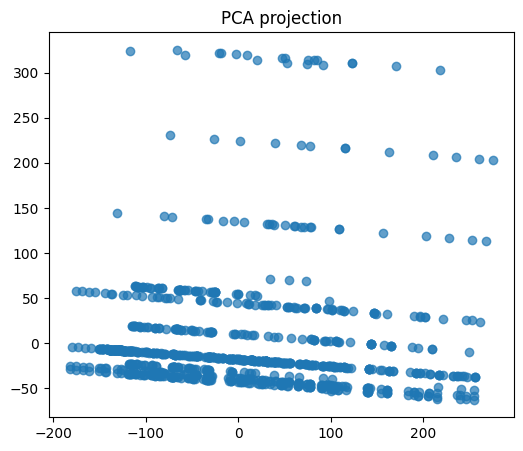

RMSE: 8.052809652860105
R²: 0.7483410839929792


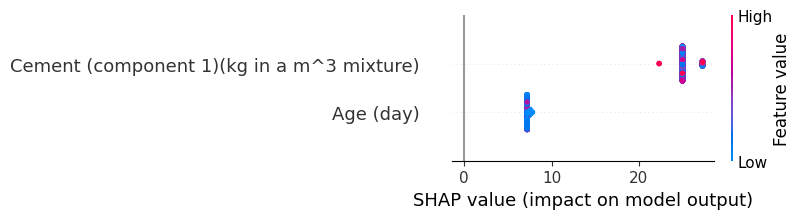

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [41]:
full_pipeline("Concrete_Data.xls", target="Concrete compressive strength(MPa, megapascals) ")


In [25]:
df = pd.read_csv("parkinsons.data", header=None)
df.head()
df.columns
df.shape


(196, 24)

In [26]:
parkinson_columns = [
    "name", "MDVP:Fo(Hz)", "MDVP:Fhi(Hz)", "MDVP:Flo(Hz)",
    "MDVP:Jitter(%)", "MDVP:Jitter(Abs)", "MDVP:RAP", "MDVP:PPQ",
    "Jitter:DDP", "MDVP:Shimmer", "MDVP:Shimmer(dB)",
    "Shimmer:APQ3", "Shimmer:APQ5", "MDVP:APQ",
    "Shimmer:DDA", "NHR", "HNR", "RPDE", "DFA",
    "spread1", "spread2", "D2", "PPE", "status"
]


In [29]:
df = pd.read_csv("parkinsons_clean.csv")
df.head()
df.info()
df.columns
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              196 non-null    object
 1   MDVP:Fo(Hz)       196 non-null    object
 2   MDVP:Fhi(Hz)      196 non-null    object
 3   MDVP:Flo(Hz)      196 non-null    object
 4   MDVP:Jitter(%)    196 non-null    object
 5   MDVP:Jitter(Abs)  196 non-null    object
 6   MDVP:RAP          196 non-null    object
 7   MDVP:PPQ          196 non-null    object
 8   Jitter:DDP        196 non-null    object
 9   MDVP:Shimmer      196 non-null    object
 10  MDVP:Shimmer(dB)  196 non-null    object
 11  Shimmer:APQ3      196 non-null    object
 12  Shimmer:APQ5      196 non-null    object
 13  MDVP:APQ          196 non-null    object
 14  Shimmer:DDA       196 non-null    object
 15  NHR               196 non-null    object
 16  HNR               196 non-null    object
 17  RPDE            

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
count,196,196,196,196,196,196,196,196,196,196,...,196,196,196,196,196,196,196,196,196,196
unique,196,196,196,196,174,21,156,166,181,189,...,190,186,196,3,196,196,196,195,196,196
top,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),0.00742,0.00003,0.00169,0.00332,0.00507,0.01608,...,0.02184,0.00839,HNR,1,RPDE,DFA,spread1,0.210279,D2,PPE
freq,1,1,1,1,3,46,5,4,3,2,...,2,2,1,147,1,1,1,2,1,1


In [40]:
import pandas as pd

df = pd.read_excel("Concrete_Data.xls")
print(df.columns.tolist())


['Cement (component 1)(kg in a m^3 mixture)', 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 'Fly Ash (component 3)(kg in a m^3 mixture)', 'Water  (component 4)(kg in a m^3 mixture)', 'Superplasticizer (component 5)(kg in a m^3 mixture)', 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)', 'Concrete compressive strength(MPa, megapascals) ']


In [39]:
full_pipeline("Concrete_Data.xls", target="Concrete compressive strength(MPa)")



Loaded: Concrete_Data.xls


KeyError: 'Concrete compressive strength(MPa)'